<a href="https://colab.research.google.com/github/syedshubha/MyJourneyQML/blob/main/qml_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pennylane
%pip install qiskit
%pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=780c4c15bce6d5cb5cae7a10b432cc73b77aba5f078c0f2d59824e6498cc7650
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [ ]:
import pennylane as qml
import numpy as np
from scipy.optimize import minimize

In [ ]:
# Define the quantum device (simulated with 3 qubits)
dev = qml.device('default.qubit', wires=3)

# Define a simple connectivity model for a device
# For a 3-qubit device with linear connectivity, we assume:
# Qubit 0 is connected to qubits 1, Qubit 1 is connected to qubits 0 and 2, Qubit 2 is connected to qubit 1.

# Define the quantum circuit (QNN) with more layers of gates
@qml.qnode(dev)
def circuit(weights, x):
    # Apply the input data as rotation on the qubits
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)

    # Apply more parameterized rotations
    qml.RZ(weights[0], wires=0)
    qml.RX(weights[1], wires=1)
    qml.RZ(weights[2], wires=2)

    # Apply entangling operations (CNOT gates)
    qml.CNOT(wires=[0, 1])  # Entangling qubits 0 and 1
    qml.CNOT(wires=[1, 2])  # Entangling qubits 1 and 2
    qml.CNOT(wires=[0, 2])  # Adding another entangling gate between 0 and 2

    # Add additional layers of rotations
    qml.RY(weights[3], wires=0)
    qml.RY(weights[4], wires=1)
    qml.RY(weights[5], wires=2)

    # Measurement (Pauli-Z)
    return qml.expval(qml.PauliZ(2))



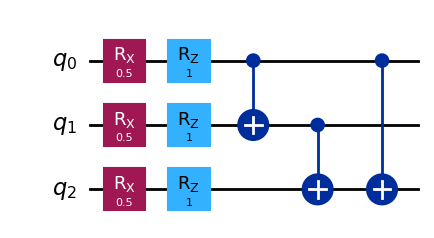

In [ ]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from pylatexenc import *
%matplotlib inline

# Create a Quantum Circuit with 3 qubits
qc = QuantumCircuit(3)

# Apply gates to the qubits
qc.rx(0.5, 0)  # RX gate on qubit 0
qc.rx(0.5, 1)  # RX gate on qubit 1
qc.rx(0.5, 2)  # RX gate on qubit 2
qc.rz(1.0, 0)  # RZ gate on qubit 0
qc.rz(1.0, 1)  # RZ gate on qubit 1
qc.rz(1.0, 2)  # RZ gate on qubit 2
qc.cx(0, 1)  # CNOT between qubit 0 and qubit 1
qc.cx(1, 2)  # CNOT between qubit 1 and qubit 2
qc.cx(0, 2)  # CNOT between qubit 0 and qubit 2

# Visualize the circuit
qc.draw('mpl')  # Draw circuit using matplotlib (this shows a grid-like diagram)




In [ ]:
# Training data (3 features, 1 label)
X_train = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
y_train = np.array([1, 0, 1])  # Labels

# Cost function for binary classification
def cost(weights, X, y):
    predictions = [circuit(weights, x) for x in X]
    return np.mean((np.array(predictions) - y) ** 2)


In [ ]:
# Function to calculate swap penalty based on the mapping
def swap_penalty(mapping):
    # Define a simple connectivity model (linear chain)
    # Penalty increases with distance between qubits
    penalty = 0
    connectivity = {
        0: [1],  # Qubit 0 is connected to 1
        1: [0, 2],  # Qubit 1 is connected to 0 and 2
        2: [1]  # Qubit 2 is connected to 1
    }

    # Calculate the number of swaps (non-local interactions)
    for i in range(3):
        for j in range(i + 1, 3):
            if j not in connectivity[mapping[i]]:
                penalty += 1  # Add penalty for non-local interaction

    return penalty

# Possible mappings of logical qubits to physical qubits
mappings = [
    [0, 1, 2],  # Mapping 1: Logical qubit 0 -> Physical qubit 0, etc.
    [1, 2, 0],  # Mapping 2: Logical qubit 0 -> Physical qubit 1, etc.
    [2, 0, 1],  # Mapping 3: Logical qubit 0 -> Physical qubit 2, etc.
]

# Initialize weights randomly
initial_weights = np.random.randn(6)  # 6 weights now due to more gates

# Function to compute cost for a given mapping
def evaluate_mapping(mapping):
    # Re-map the qubits in the circuit according to the mapping
    @qml.qnode(dev)
    def mapped_circuit(weights, x):
        # Apply the input data as rotation on the mapped qubits
        qml.RX(x[mapping[0]], wires=0)
        qml.RX(x[mapping[1]], wires=1)
        qml.RX(x[mapping[2]], wires=2)

        # Apply more parameterized rotations
        qml.RZ(weights[0], wires=0)
        qml.RX(weights[1], wires=1)
        qml.RZ(weights[2], wires=2)

        # Apply entangling operations (CNOT gates)
        qml.CNOT(wires=[0, 1])  # Entangling qubits 0 and 1
        qml.CNOT(wires=[1, 2])  # Entangling qubits 1 and 2
        qml.CNOT(wires=[0, 2])  # Adding another entangling gate between 0 and 2

        # Add additional layers of rotations
        qml.RY(weights[3], wires=0)
        qml.RY(weights[4], wires=1)
        qml.RY(weights[5], wires=2)

        # Measurement (Pauli-Z)
        return qml.expval(qml.PauliZ(2))

    # Minimize the cost function for this mapping
    result = minimize(lambda w: cost(w, X_train, y_train), initial_weights, method='BFGS')

    # Add the penalty for swap gates based on the mapping
    penalty = swap_penalty(mapping)
    return result.fun + penalty  # Include penalty in the total cost


In [ ]:
# Evaluate all mappings
mapping_costs = {}
for i, mapping in enumerate(mappings):
    cost_value = evaluate_mapping(mapping)
    mapping_costs[f'Mapping {i+1}'] = cost_value

# Show the results
print("Cost for each mapping (including swap penalty):")
for mapping, cost_value in mapping_costs.items():
    print(f"{mapping}: {cost_value:.4f}")


Cost for each mapping (including swap penalty):
Mapping 1: 1.2266
Mapping 2: 2.2266
Mapping 3: 2.2266
